# CarGurus.com Scrape
- Notes: scraped September 2020. Good data. Description, major options, etc
- 3m obs, 66 vars
- https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset
- original filename used_cars_data.csv

In [1]:
import numpy as np
import pandas as pd

In [11]:
# read df
# pre-defined df types for performance
df = pd.read_csv('df/cargurus.csv'
                    ,low_memory = False
                    ,nrows = 50000
                    ,dtype={
                            'vin': object, 
                            'back_legroom': object ,
                            'bed': object , # Type String. Category of bed size(open cargo area) in pickup truck. Null usually means the vehicle isn't a pickup truck
                            'bed_height': object , 
                            'bed_length': object , 
                            'body_type' : object , 
                            'cabin' : object, # Type String. Category of cabin size(open cargo area) in pickup truck. Eg: Crew Cab, Extended Cab, etc.
                            'city' :'object' , # Type String. city where the car is listed. Eg: Houston, San Antonio, etc.
                            'city_fuel_economy' : float, 
                            'combine_fuel_economy' : float, 
                            'daysonmarket' : int , # Type Integer. Days since the vehicle was first listed on the website.
                            'dealer_zip' : int , 
                            'description' :object , # Type String. Vehicle description on the vehicle's listing page
                            'engine_cylinders' :object , 
                            'engine_displacement' : float,
                            'engine_type' : object , 
                            'exterior_color' : object , 
                            'fleet' :'bool' , # Type Boolean. Whether the vehicle was previously part of a fleet.
                            'frame_damaged' : 'bool' , # Type Boolean. Whether the vehicle has a damaged frame.
                            'franchise_dealer' : 'bool', # Type Boolean. Whether the dealer is a franchise dealer.
                            'franchise_make' : object , # Type String. The company that owns the franchise.
                            'front_legroom' :object ,
                            'fuel_tank_volume' : object ,
                            'fuel_type' :object ,
                            'has_accidents' : 'bool' , # Whether the vin has any accidents registered.
                            'height' :object ,
                            'highway_fuel_economy' : float,
                            'horsepower' : float,
                            'interior_color' : object ,
                            'isCab' : 'bool' , # Whether the vehicle was previously taxi/cab.
                            'is_certified' : 'bool', # Whether the vehicle is certified. Certified cars are covered through warranty period
                            'is_cpo' : 'bool' , # Pre-owned cars certified by the dealer
                            'is_new' :'bool' , # If True means the vehicle was launched less than 2 years before 2020.
                            'is_oemcpo' :object , # Pre-owned cars certified by the manufacturer
                            'latitude' : float,
                            'length' :object ,
                            'listed_date' :object ,
                            'listing_color' :object ,
                            'listing_id' : int ,
                            'longitude' : float,
                            'main_picture_url' :object ,
                            'major_options' :object ,
                            'make_name' : object ,
                            'maximum_seating' :object,
                            'mileage' : int,
                            'model_name' : object,
                            'owner_count' : float,
                            'power' : object ,
                            'price' : float,
                            'salvage' :object,
                            'savings_amount' : int ,
                            'seller_rating' : float,
                            'sp_id' : int,
                            'sp_name' : object ,
                            'theft_title' : object ,
                            'torque' :object ,
                            'transmission' : object ,
                            'transmission_display' : object ,
                            'trimId' :object ,
                            'trim_name' : object ,
                            'vehicle_damage_category' : float,
                            'wheel_system' : object,
                            'wheel_system_display' : object,
                            'wheelbase' : object,
                            'width' : object,
                            'year' : int 
                            })

print(df.shape)
df.head()

(50000, 66)


,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [12]:
print(df.columns)
print(df.info())

Index(['vin', 'back_legroom', 'bed', 'bed_height', 'bed_length', 'body_type',
       'cabin', 'city', 'city_fuel_economy', 'combine_fuel_economy',
       'daysonmarket', 'dealer_zip', 'description', 'engine_cylinders',
       'engine_displacement', 'engine_type', 'exterior_color', 'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_certified', 'is_cpo', 'is_new', 'is_oemcpo', 'latitude', 'length',
       'listed_date', 'listing_color', 'listing_id', 'longitude',
       'main_picture_url', 'major_options', 'make_name', 'maximum_seating',
       'mileage', 'model_name', 'owner_count', 'power', 'price', 'salvage',
       'savings_amount', 'seller_rating', 'sp_id', 'sp_name', 'theft_title',
       'torque', 'transmission', 'transmission_display', 'trimId', 'trim_name',
       'vehicle_damage_category', 'whe

In [9]:
# numeric
df.describe().round(decimals = 1)

,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,42557.0,0.0,50000.0,50000.0,47328.0,42557.0,47328.0,0.0,50000.0,50000.0,50000.0,48171.0,28688.0,50000.0,50000.0,49621.0,50000.0,0.0,50000.0
mean,22.1,NaN,76.9,15545.4,2803.0,29.1,246.3,NaN,41.1,275302156.0,-75.5,33897.5,1.5,29657.6,813.4,4.1,254416.6,NaN,2017.3
std,7.7,NaN,111.2,15309.5,1129.7,7.1,85.9,NaN,1.3,9111596.4,3.8,44759.4,0.8,21671.0,1379.3,0.6,123884.4,NaN,4.0
min,10.0,NaN,0.0,922.0,700.0,11.0,70.0,NaN,18.3,98730625.0,-118.4,0.0,1.0,795.0,0.0,1.0,47865.0,NaN,1930.0
25%,18.0,NaN,14.0,7083.0,2000.0,25.0,179.0,NaN,40.7,274672190.2,-74.5,6.0,1.0,17486.0,0.0,3.6,156550.0,NaN,2017.0
50%,21.0,NaN,36.0,8807.0,2500.0,28.0,241.0,NaN,40.9,278403960.5,-74.1,19749.0,1.0,26231.5,94.0,4.2,282608.0,NaN,2018.0
75%,25.0,NaN,80.0,11743.0,3500.0,33.0,295.0,NaN,41.6,280300179.2,-73.5,46022.5,2.0,37725.0,1204.0,4.6,342815.0,NaN,2020.0
max,127.0,NaN,2150.0,91401.0,8400.0,122.0,808.0,NaN,43.3,281672377.0,-66.1,341893.0,12.0,1390000.0,58542.0,5.0,439840.0,NaN,2021.0


In [10]:
# non-numeric
df.describe(include = ['object','category'])

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,description,engine_cylinders,...,theft_title,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width
count,50000,47503,424,3432,3432,49771,676,50000,47888,48564,...,30058,42216,49574,49574,48059,48046,47660,47660,47503,47503
unique,50000,176,3,1,62,9,4,254,40523,28,...,2,1132,4,33,10225,3041,5,5,381,252
top,ZACNJABB5KPJ92081,38.3 in,Long,--,67.1 in,SUV / Crossover,Crew Cab,Waterbury,Varsity Lincoln is the #1 volume Lincoln deale...,I4,...,False,"390 lb-ft @ 4,250 RPM",A,Automatic,t86414,SE FWD,AWD,All-Wheel Drive,112.2 in,72.4 in
freq,1,2499,173,3432,799,25755,445,1212,271,25820,...,29909,1010,42991,24785,823,1429,22462,22462,3772,1747


In [25]:
# vin unique
df.set_index("vin", inplace=True)
df.index.duplicated().sum()

0

In [27]:
a = df.power.str.replace(",", "").str.split().str[0:4:3]
a = pd.dfFrame([[np.nan, np.nan] if type(i).__name__ == "float" else np.asarray(i).astype("float") for i in a],
                 columns=["horsepower", "horsepower_rpm"])
df[["horsepower", "horsepower_rpm"]] = a


a = df.torque.str.replace(",", "").str.split().str[0:4:3]
a = pd.DataFrame([[np.nan, np.nan] if type(i).__name__ == "float" else np.asarray(i).astype("float") for i in a], 
                 columns=["torque", "torque_rpm"])
df[["torque", "torque_rpm"]] = a

del a

In [28]:
df.bed_length = df.bed_length.replace("--", np.nan)
df.bed_length = df.bed_length.str.split().str[0].astype(float)

In [29]:
extract_num_from_series_single_unit = lambda series: series.str.split().str[0].astype(float)

columns = ["back_legroom", "wheelbase", "width", "length", "height", 
           "fuel_tank_volume", "front_legroom", "maximum_seating"]

df[columns] = df[columns].replace({",": "", "--": np.nan}).apply(extract_num_from_series_single_unit)

# df.major_options = df.major_options.apply(lambda x: eval(x) if type(x).__name__ == "str" else (np.nan if x == "[]" else x))

In [30]:
drop_columns = ["bed_height", "power", "vehicle_damage_category"]
df.drop(columns=drop_columns, inplace=True)

In [33]:
a = df.major_options.apply(lambda x: pd.Series([]) if len(str(x)) <= 3 else pd.Series(eval(x)))
a

/var/folders/nl/d1z3_54n5kb053_jgq9kvjnh0000gn/T/ipykernel_42847/4213858397.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  a = df.major_options.apply(lambda x: pd.Series([]) if len(str(x)) <= 3 else pd.Series(eval(x)))


,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
vin,,,,,,,,,,,,,,,,,,,,,
ZACNJABB5KPJ92081,Quick Order Package,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SALCJ2FX1LH858117,Adaptive Cruise Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JF1VA2M67G9829723,Alloy Wheels,Bluetooth,Backup Camera,Heated Seats,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SALRR2RV0L2433391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SALCJ2FXXLH862327,Adaptive Cruise Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SADCS2FX4KA605793,Sunroof/Moonroof,Alloy Wheels,Bluetooth,Backup Camera,Remote Start,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5UXKR0C59J0X94891,Sunroof/Moonroof,Navigation System,Alloy Wheels,Bluetooth,Backup Camera,Premium Package,Heated Seats,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2T3BK4DV5BW041139,Value Package,Extra Value Package,Steel Wheels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df["listing_color"].value_counts()

BLACK      11968
WHITE      10770
GRAY        6515
UNKNOWN     5823
SILVER      5655
BLUE        4381
RED         3487
GREEN        506
BROWN        378
ORANGE       174
GOLD         152
YELLOW        86
TEAL          68
PURPLE        30
PINK           7
Name: listing_color, dtype: int64

In [35]:
categorical_columns = ["body_type", "wheel_system"]
pd.get_dummies(df[categorical_columns], drop_first=True)

,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,wheel_system_4X2,wheel_system_AWD,wheel_system_FWD,wheel_system_RWD
vin,,,,,,,,,,,,
ZACNJABB5KPJ92081,0,0,0,0,1,0,0,0,0,0,1,0
SALCJ2FX1LH858117,0,0,0,0,1,0,0,0,0,1,0,0
JF1VA2M67G9829723,0,0,0,0,0,1,0,0,0,1,0,0
SALRR2RV0L2433391,0,0,0,0,1,0,0,0,0,1,0,0
SALCJ2FXXLH862327,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
SADCS2FX4KA605793,0,0,0,0,1,0,0,0,0,1,0,0
5UXKR0C59J0X94891,0,0,0,0,1,0,0,0,0,1,0,0
2T3BK4DV5BW041139,0,0,0,0,1,0,0,0,0,0,0,0


In [16]:
# numeric var correlations

import plotly.figure_factory as ff

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
fig = ff.create_annotated_heatmap(
    z=corr.to_numpy().round(2),
    x=list(corr.index.values),
    y=list(corr.columns.values),       
    xgap=3, ygap=3,
    zmin=-1, zmax=1,
colorscale='icefire',
    colorbar_thickness=30,
    colorbar_ticklen=3,
)
fig.update_layout(title_text='Correlation Matrix (impact relationship with numbers)',
                  title_x=0.5,
                  titlefont={'size': 20},
                  width=1200, height=1200,
                  xaxis_showgrid=False,
                  xaxis={'side': 'bottom'},
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed',                   
                  paper_bgcolor=None,
                  template="simple_white"
                  )
fig.show()

### Check for univariate linear relationships

In [18]:
from pandas import DataFrame
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib as mpl
import matplotlib.pyplot as plt

# target
price = DataFrame(df, columns=['price'])

# predictors
year = DataFrame(df, columns=['year'])
mileage = DataFrame(df, columns=['mileage'])
owner_count = DataFrame(df, columns=['owner_count'])

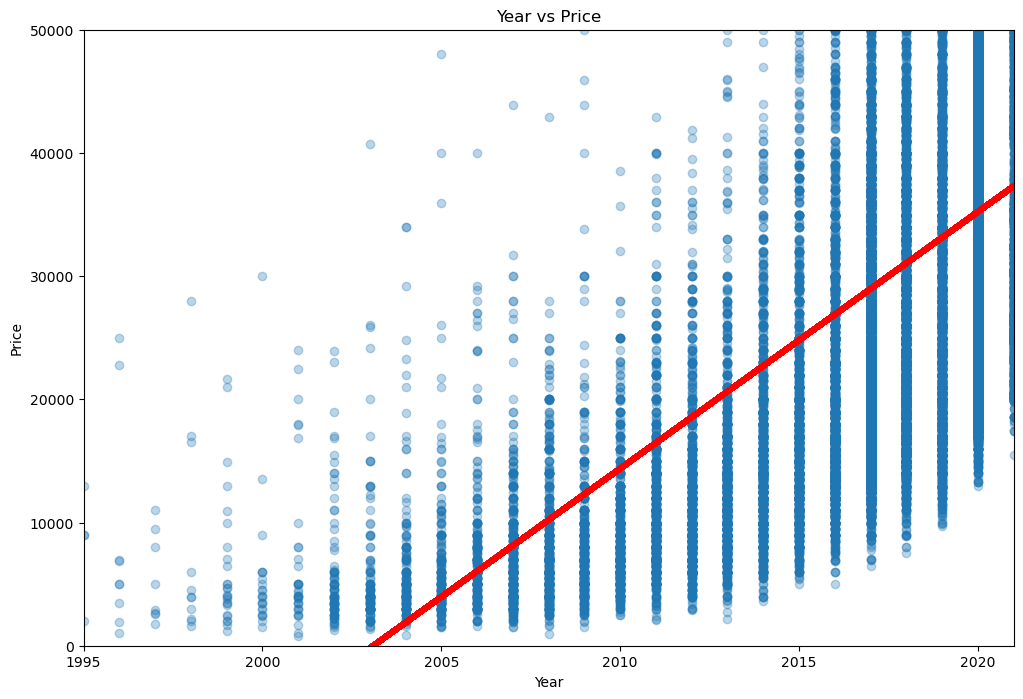

Regression coeficent: 2083.47
Mean squared error: 1233539091.98
Coefficient of determination: -78212867.48


In [20]:
# year vs price

plt.figure(figsize=(12,8))
plt.scatter(year, price, alpha = 0.3)
#Draws the Linear Regression
regression = linear_model.LinearRegression()
regression.fit(year, price)
plt.plot(year, regression.predict(year), color='red', linewidth=4)
plt.title('Year vs Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.ylim(0, 50000)
plt.xlim(1995, 2021)
plt.show()

#Step7:Calculating the Regression Theta Coefficient:
print('Regression coeficent: %.2f' % regression.coef_ )#theta_1
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(year, price))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(year, price))

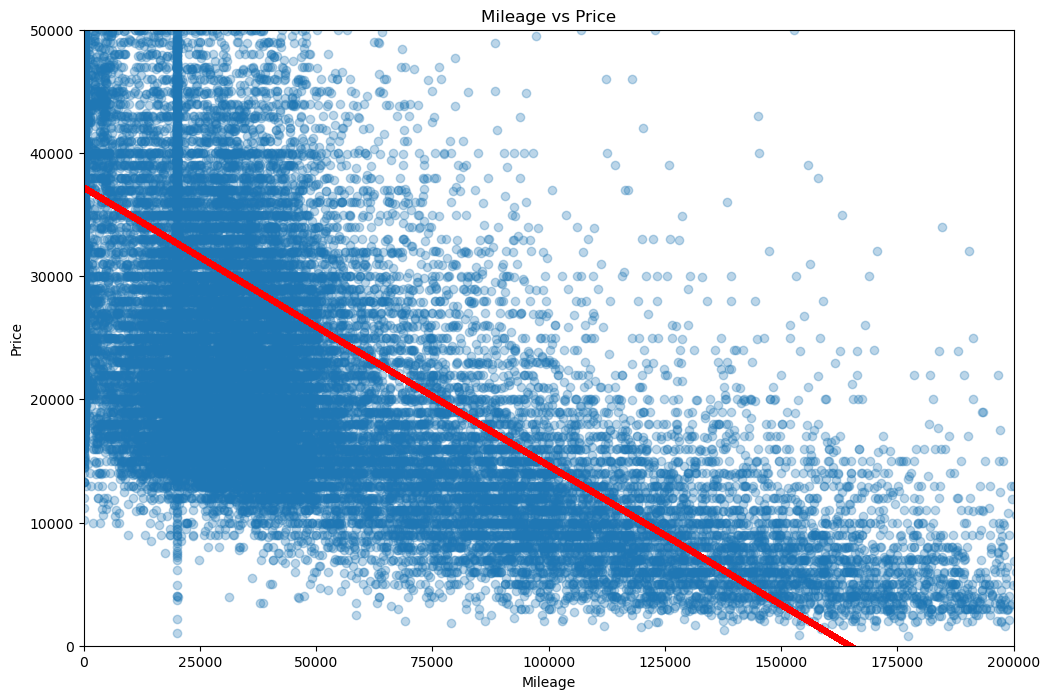

Regression coeficent: -0.23
Mean squared error: 3295038182.45
Coefficient of determination: -0.70


In [21]:
# mileage vs price

#Filling the NAN Values with average values for the column
mileage = DataFrame(df, columns=['mileage']).fillna(value=20000)
#Step6: Updating the previous code to draw the LinearRegression
plt.figure(figsize=(12,8))
plt.scatter(mileage, price, alpha = 0.3)
#Draws the Linear Regression
regression = linear_model.LinearRegression()
regression.fit(mileage, price)
plt.plot(mileage, regression.predict(mileage), color='red', linewidth=4)
plt.title('Mileage vs Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.ylim(0, 50000)
plt.xlim(0, 200000)
plt.show()

#Step7:Calculating the Regression Theta Coefficient:
print('Regression coeficent: %.2f' % regression.coef_ )#theta_1
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(mileage, price))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(mileage, price))

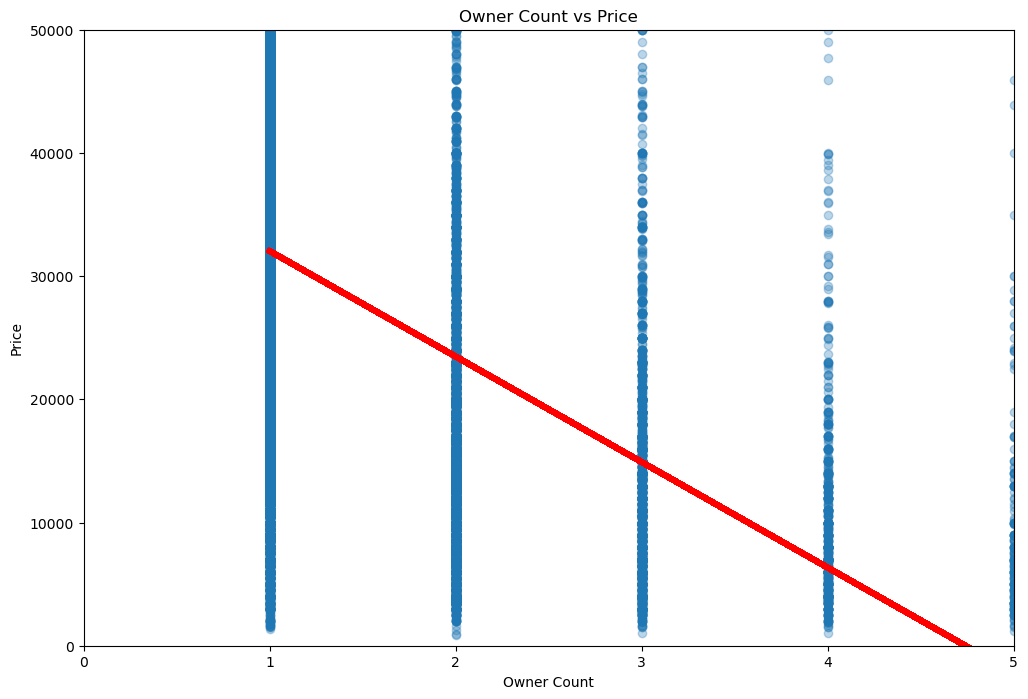

Regression coeficent: -8564.95
Mean squared error: 1349125700.32
Coefficient of determination: -2910691009.93


In [22]:
# owner_count vs price

#Filling the NAN Values with average values for the column
owner_count = DataFrame(df, columns=['owner_count']).fillna(value=1)
#Step6: Updating the previous code to draw the LinearRegression
plt.figure(figsize=(12,8))
plt.scatter(owner_count, price, alpha = 0.3)
#Draws the Linear Regression
regression = linear_model.LinearRegression()
regression.fit(owner_count, price)
plt.plot(owner_count, regression.predict(owner_count), color='red', linewidth=4)
plt.title('Owner Count vs Price')
plt.xlabel('Owner Count')
plt.ylabel('Price')
plt.ylim(0, 50000)
plt.xlim(0, 5)
plt.show()

#Step7:Calculating the Regression Theta Coefficient:
print('Regression coeficent: %.2f' % regression.coef_ )#theta_1
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(owner_count, price))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(owner_count, price))

In [23]:
import plotly.graph_objects as go

#controls the numer of rows to be read in the dataframe
start, end = 0, 20000
fig = go.Figure(data=go.Scatter3d(
    x=df['year'][start:end],
    y=df['mileage'][start:end],
    z=df['owner_count'][start:end],
    text=df['model_name'][start:end],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=12000,
        size=df['price'][start:end],
        color = df['highway_fuel_economy'][start:end],
        colorscale = 'Viridis',
        colorbar_title = 'highway_fuel_economy<br>',
        line_color='rgb(140, 140, 170)'
    )
))








fig.update_layout(height=600, width=600,
                  title='3-D Graph - X-Year,Y-Mileage,Z-Owner Count,Size-Price,Color-Highway MPG')

In [ ]:
# find that countour plot in another notebook